# Full Train Workflow

Run when you need to train a new classifier from scratch. Will regenerate transient data, refit all samples, and retrain the classifier.

## Step 0: Update configuration file.

In the same folder as this notebook, there is a $\texttt{config.yaml}$ file, which contains all filepaths and configuration options for the training workflow. Please update this now!

The most important filepath arguments are:
* $\texttt{create-dirs}$: Probably keep set to True. Create any data subdirectories that are missing.
* $\texttt{data-dir}$: This is where all generated data is stored. Set to the root directory for all outputs.
* $\texttt{relative-dirs}$: If true, all data for each step is stored within subdirectories of data_dir.
* $\texttt{transient-data-fn}$: This is where all transient data is stored as a TransientGroup. Technically a directory but loaded as a single file. If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{sampler-results-fn}$: Where light curve fits are stored. If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{figs-dir}$: Where all figures are stored (only generated if $\texttt{plot}$ is set to True). If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{models-dir}$: Where all classification models are stored. If relative_dirs is True, is created as a subdirectory of data_dir.

The most important sampling and classifier arguments are:
* $\texttt{sampler}$: Set to either dynesty or svi (all lowercase). SVI is faster but forces the posterior into a multivariate Gaussian.
* $\texttt{model-type}$: Set to either LightGBM (recommended) or MLP.
* $\texttt{use-redshift-features}$: If True, includes peak absolute magnitude and redshift as training features.
* $\texttt{fits-per-majority}$: Oversamples such that the majority class has this many samples fed into the classifier. Minority classes will correspond to more input samples per event. Defaults to 5.
* $\texttt{target-label}$: For binary classification - this is the positive label. Set to None for multiclass classification.
* $\texttt{n-folds}$: Number of K-folds. I usually set to 10.
* $\texttt{num-epochs}$: Number of estimators for LightGBM or number of training epochs for MLP.
* $\texttt{n-parallel}$: Number of threads to parallelize data import + sampling over.
* $\texttt{random-seed}$: For reproducibility.

If you want to use hierarchical classification with the MLP, you need to also manually fill in the following:
* $\texttt{hierarchy}$: Set to True if you want to use the weighted hierarchical loss function (WHXE). Otherwise, make sure this is set to False.
* $\texttt{class-weights}$: Manually import these values using the class_weights.ipynb notebook to calculate the relevant class weights for the (WHXE). If you are not using this, set it to null.
* $\texttt{graph}$: This is a dictionary of properties of the taxonomic graph. Set each element to null if not using the WHXE.
    * $\texttt{edges}$: A list of tuples containing the edges in the taxonomic graph in use. If not using WHXE, set to null.
    * $\texttt{height}$: The height you want the classifier to go to in terms of the taxonomic tree. Set to null if not using WHXE.
    * $\texttt{root}$: The root node of the tree as a string. This is set to null if not using WHXE.
    * $\texttt{vertices}$: A list of all of the vertices within the tree, including those that are not labels within the dataset. Set to null if not using WHXE.   

## Step 1: Generate new TransientSet

Here we will import data from TNS + ALeRCE and generate a new TransientSet, from a list of event names. Names can be from TNS or ZTF.

The below code block will retrieve all spectroscopically classified TNS transients. Feel free to change to your own list of names or import script.

In [1]:
from pathlib import Path
import os
from snapi.query_agents import TNSQueryAgent

p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data", "tutorial")
print(SAVE_DIR)

tns_agent = TNSQueryAgent(db_path=SAVE_DIR)
#tns_agent.update_local_database() # IMPORTANT: run this line if first time using SNAPI or if you want to reimport TNS csv
all_names = tns_agent.retrieve_all_names() # only spectroscopically classified
all_names = [x for x in all_names if int(x[:4]) > 2018] # because pre-2019 templates are pretty bad
print(len(all_names), all_names[:5])

/Users/charisgraham/Desktop/Summer2025/superphotplus/superphot-plus/data/tutorial
15594 ['2025mbd', '2025myk', '2025ldk', '2025nac', '2025mxf']


The following script will import data for all provided names and generate a TransientGroup object. Will run in parallel across n_cores threads.

For the entire TNS dataset (~16000 events), this takes ~30 minutes on 8 parallel cores.

------------------TESTING----------------------------

In [1]:
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
print(config.use_hierarchy)
print(config.class_weights)
print(config.graph)
print(config.graph['height'])
print(len(config.class_weights))
print(len(config.graph['vertices']))


/opt/miniconda3/envs/superphot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: Root must be a valid vertex.

----------------END TESTING------------------------------

In [7]:
# First augments the config file to save to your data folder path!
# Feel free to change to any path you want
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
config.update(data_dir=SAVE_DIR)
config.write_to_file('config.yaml')


In [3]:
from superphot_plus.config import SuperphotConfig
from superphot_plus.data_generation import import_all_names

config = SuperphotConfig.from_file("config.yaml")
save_dir = config.transient_data_fn

# import data for all_names from query agents
import_all_names(
    all_names, save_dir,
    checkpoint_freq=1024,
    n_cores=config.n_parallel,
    overwrite=True,
    skipped_names_fn = os.path.join(config.data_dir, "skipped_names.txt")
) # set overwrite=False to continue from where left off

15594 names to query across 8 cores.
Processing 1040 transients in batch
Finished processing, making transient group now
Total transients saved: 0.
Processing 1040 transients in batch
Finished processing, making transient group now
Total transients saved: 160.
Processing 1040 transients in batch
Empty DataFrame
Columns: [fid, filt_center, filt_width, filter, flux, flux_error, mag, mag_error, upper_limit, zeropoint]
Index: []
Empty DataFrame
Columns: [fid, filt_center, filt_width, filter, flux, flux_error, mag, mag_error, upper_limit, zeropoint]
Index: []
Empty DataFrame
Columns: [fid, filt_center, filt_width, filter, flux, flux_error, mag, mag_error, upper_limit, zeropoint]
Index: []
Finished processing, making transient group now
Total transients saved: 702.
Processing 1040 transients in batch
Empty DataFrame
Columns: [fid, filt_center, filt_width, filter, flux, flux_error, mag, mag_error, upper_limit, zeropoint]
Index: []
Empty DataFrame
Columns: [fid, filt_center, filt_width, filter

In [4]:
# Let's check the TransientGroup we created!
from snapi import TransientGroup
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)

print(len(transient_group.metadata))
print(transient_group.metadata.head())
print(transient_group.metadata.groupby('spec_class').count())

5092
                  ra        dec                    internal_names spec_class  \
id                                                                             
2019aamp  219.455292  20.304611                      ZTF19aantokv     SLSN-I   
2019aanx  112.499958  13.095333                      ZTF19ackiwff    SLSN-II   
2019aaot    3.069526  -5.727405                      ZTF19aazdroc        AGN   
2019aas   204.664167  55.451900  PS19cuv, Gaia19ahb, ZTF18adbacau      SN II   
2019aauh  155.937245  24.989687                      ZTF19aaoiawb        QSO   

          redshift  
id                  
2019aamp  0.404000  
2019aanx  0.403000  
2019aaot  0.283000  
2019aas   0.037033  
2019aauh  0.394639  
                     ra   dec  internal_names  redshift
spec_class                                             
AGN                  26    26              26        26
CV                   71    71              71        45
Galaxy                3     3               3         3
ILRT   

Finally, before fitting, we want to phase and normalize all the photometry. This is because our samplers expect light curves to already be phased and normalized before fitting.

## Step 2 (Option 1): Fit all transients using SVI (faster)

Here, we choose to fit our transients using stochastic variational inference (SVI). If using this option, make sure sampler='superphot_svi' in the config.yaml file. This option is faster but assumes Gaussianity of the posterior space, which can be limiting for certain light curve fits.

For all 7202 TNS transients passing quality cuts, this takes ~30 minutes.

In [5]:
from snapi.scripts import fit_transient_group
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus.samplers.numpyro_sampler import SVISampler
from superphot_plus.priors import generate_priors, SuperphotPrior
from superphot_plus.config import SuperphotConfig
import os
from pathlib import Path

p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data", "tutorial")

config = SuperphotConfig.from_file("config.yaml")

#priors = generate_priors(["ZTF_r","ZTF_g"])
priors = SuperphotPrior.load(SAVE_DIR + "/" + "global_priors_hier_svi")
svi_sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=config.random_seed,
)

transient_group = TransientGroup.load(config.transient_data_fn)
print("Transient group loaded")

result = fit_transient_group(
    transient_group,
    sampler = svi_sampler,
    parallelize=True,
    n_parallel=config.n_parallel,
    checkpoint_fn = os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    ),
    checkpoint_freq = 512,
    pad=True,
    overwrite=True # set to False to continue where left off
)
SamplerResultGroup(result).save(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

INFO:2025-06-20 13:43:43,032:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-06-20 13:43:43,032 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']
Transient group loaded


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-06-20 13:44:15,405:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-06-20 13:44:15,405 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/Sys

Finished checkpoint 1 of 9


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-06-20 13:45:15,880:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-06-20 13:45:15,880 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/Sys

Finished checkpoint 2 of 9


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-06-20 13:46:18,335:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-06-20 13:46:18,335 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/Sys

Finished checkpoint 3 of 9


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-06-20 13:47:20,328:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-06-20 13:47:20,328 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/Sys

Finished checkpoint 4 of 9


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-06-20 13:48:23,207:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-06-20 13:48:23,207 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/Sys

Finished checkpoint 5 of 9


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-06-20 13:49:30,655:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-06-20 13:49:30,655 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/Sys

Finished checkpoint 6 of 9


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-06-20 13:50:39,029:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-06-20 13:50:39,029 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/Sys

Finished checkpoint 7 of 9


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-06-20 13:51:44,732:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-06-20 13:51:44,732 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/Sys

Finished checkpoint 8 of 9


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-06-20 13:52:58,438:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-06-20 13:52:58,438 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/Sys

Finished checkpoint 9 of 9


['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']
5092         A_ZTF_r_median  beta_ZTF_r_median  gamma_ZTF_r_median  \
id                                                              
2025ud        0.960837           0.004838           20.243164   
2025wl        0.973447           0.004554           21.217979   
2025xj        1.031060           0.004454           12.996687   
2025yd        0.901626           0.004677           15.295027   
2025yz        0.976098           0.004658           10.835089   

        t_0_ZTF_r_median  tau_rise_ZTF_r_median  tau_fall_ZTF_r_median  \
id                                                                       
2025ud         -9.163007               0.470369              70.247452   
2025wl         -8.152984              

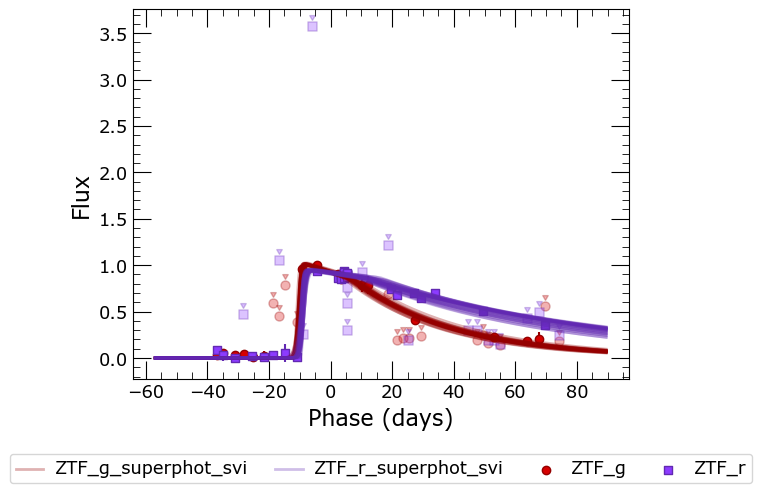

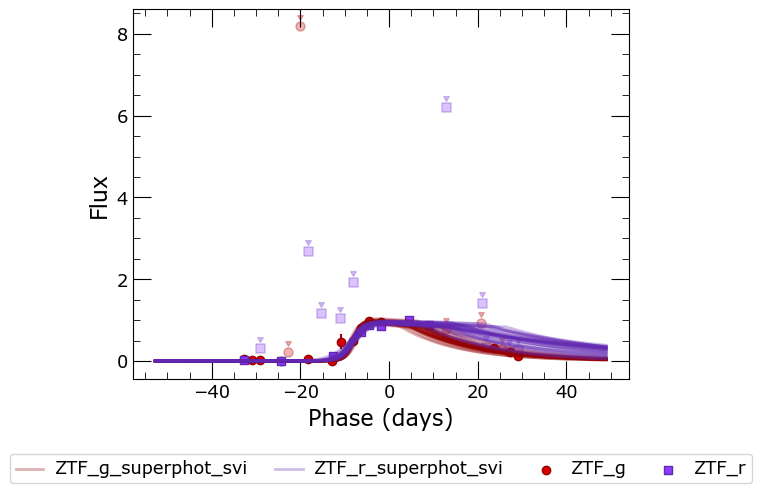

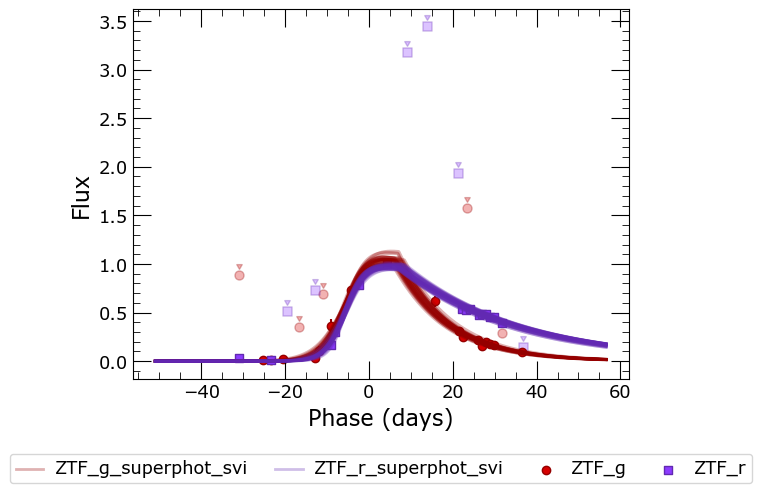

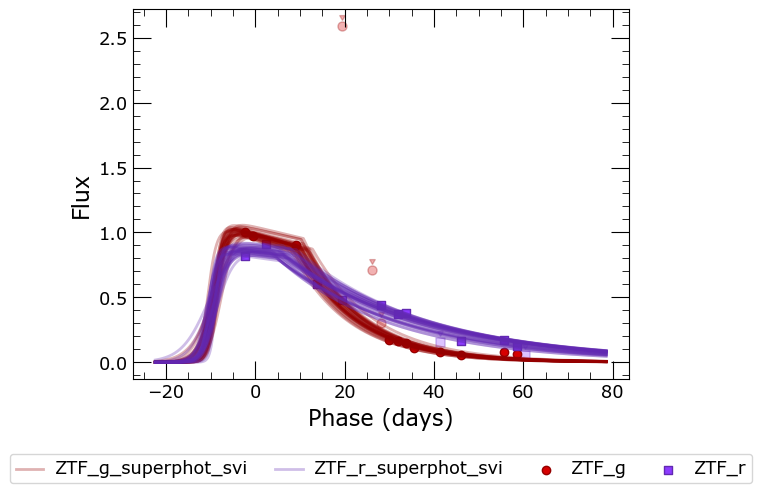

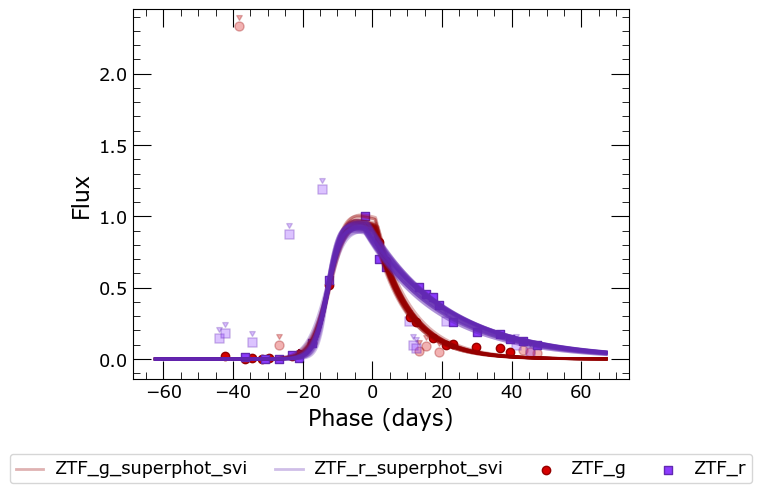

In [6]:
# sanity check plot
import os
import matplotlib.pyplot as plt

from snapi import TransientGroup, SamplerResultGroup, Formatter
from superphot_plus.samplers.numpyro_sampler import SVISampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
sampler_results = SamplerResultGroup.load(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

priors = generate_priors(["ZTF_r","ZTF_g"])
svi_sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=config.random_seed,
)

print(len(sampler_results), sampler_results.metadata.tail())
names = sampler_results.metadata.index

formatter = Formatter()
for n in names[-5:]:
    t = transient_group[n] # can index like dictionary
    sr = sampler_results[n]
    svi_sampler.load_result(sr)
    
    fig, ax = plt.subplots()
    svi_sampler.plot_fit(
        ax,
        photometry = t.photometry,
        formatter = formatter,
    )
    formatter.reset_colors()
    formatter.reset_markers()
    t.photometry.plot(
        ax,
        mags=False,
        formatter=formatter
    )
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    formatter.reset_colors()
    formatter.reset_markers()
    
    plt.show()
    

## Step 2 (Option 2): Fit light curves using dynesty (slower)

Here, we fit our transient photometry using the dynesty nested sampler. This is slower but does not assume Gaussianity of the posterior space, so can better capture degeneracies between parameters. If you use this, make sure to set sampler=superphot_dynesty in the config.yaml file.

Runtime for 7202 TNS samples: ~200 minutes (3.5 hours)

In [ ]:
from snapi.scripts import fit_transient_group
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus.samplers.dynesty_sampler import DynestySampler
from superphot_plus.priors import generate_priors, SuperphotPrior
from superphot_plus.config import SuperphotConfig

from pathlib import Path
import os

p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data", "tutorial")

config = SuperphotConfig.from_file("config.yaml")

#priors = generate_priors(["ZTF_r","ZTF_g"])
priors = SuperphotPrior.load(SAVE_DIR + "/" + "global_priors_hier_svi")

transient_group = TransientGroup.load(config.transient_data_fn)
print("Transient group loaded")

priors = generate_priors(["ZTF_r","ZTF_g"])

dynesty_sampler = DynestySampler(
    priors=priors,
    random_state=config.random_seed,
)

result = fit_transient_group(
    transient_group,
    sampler = dynesty_sampler,
    parallelize=True,
    n_parallel=config.n_parallel,
    checkpoint_fn = os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    ),
    checkpoint_freq = 128,
    pad=False,
    overwrite=True, # False to continue from checkpoint
)
SamplerResultGroup(result).save(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    ),
)


Transient group loaded


/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/dynesty/dynamicsampler.py:530: RuntimeWarning: All the initial likelihood values are the same. You likely have a plateau in the likelihood. Nested sampling may not be the best sampler in this case.
  warnings.warn(
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:33:39,406 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:33:39,406 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03

Finished checkpoint 0 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 1 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 2 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:44:05,388 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:44:05,388 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:44:05,388 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:44:05,389 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 3 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:47:44,712 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:47:44,713 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:47:44,714 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:47:44,715 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 4 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:51:17,464 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:51:17,464 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:51:17,464 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:51:17,465 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 5 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()


KeyboardInterrupt: 

/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/dynesty/dynamicsampler.py:530: RuntimeWarning: All the initial likelihood values are the same. You likely have a plateau in the likelihood. Nested sampling may not be the best sampler in this case.
  warnings.warn(


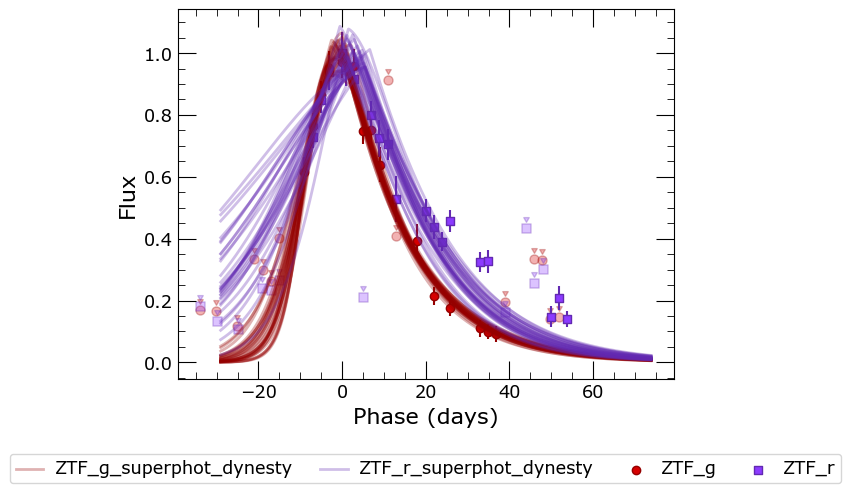

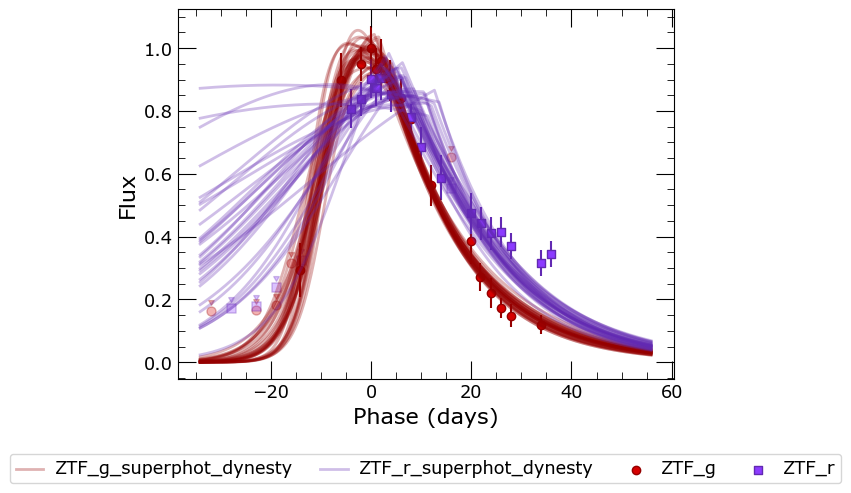

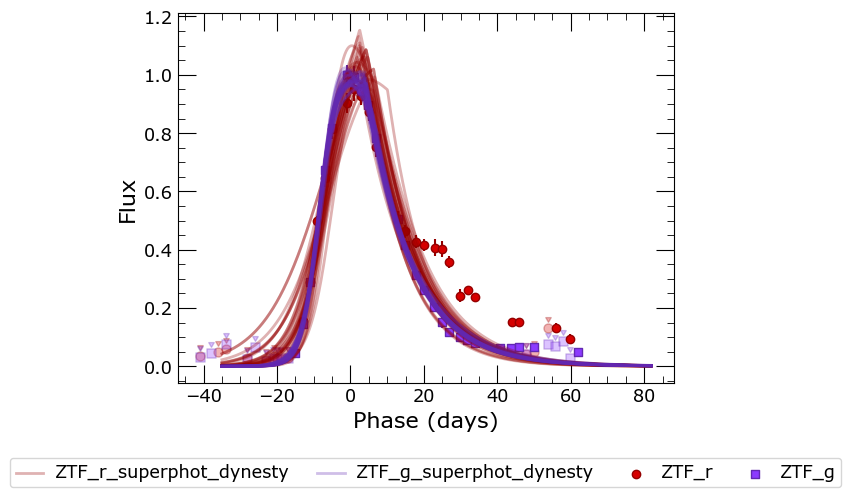

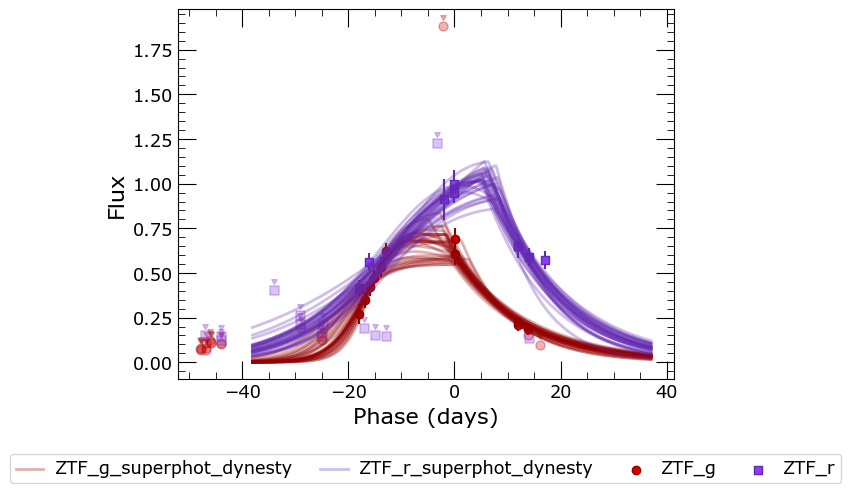

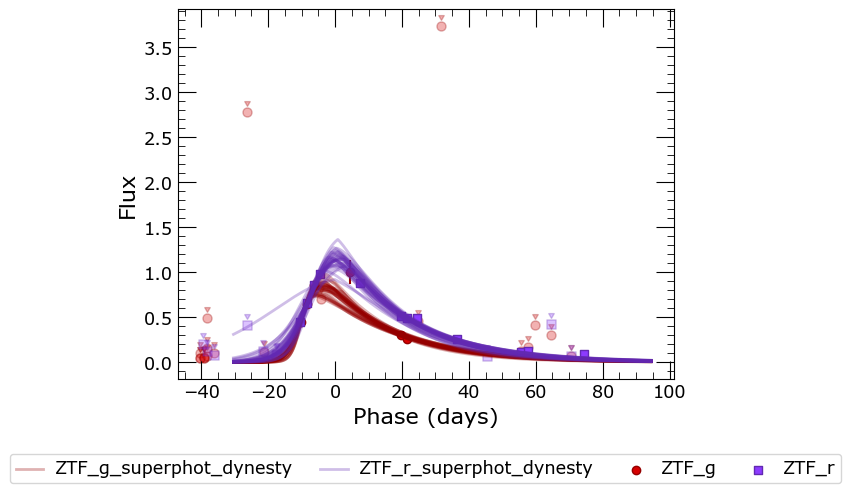

In [ ]:
# sanity check plot
import os
import matplotlib.pyplot as plt

from snapi import TransientGroup, SamplerResultGroup, Formatter
from superphot_plus.samplers.dynesty_sampler import DynestySampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
sampler_results = SamplerResultGroup.load(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

priors = generate_priors(["ZTF_r","ZTF_g"])

svi_sampler = DynestySampler(
    priors=priors,
    random_state=config.random_seed,
)

names = sampler_results.metadata.index

formatter = Formatter()
for n in names[-5:]: # neweet 
    t = transient_group[n] # can index like dictionary
    sr = sampler_results[n]
    svi_sampler.load_result(sr)
    
    fig, ax = plt.subplots()
    svi_sampler.plot_fit(
        ax,
        photometry = t.photometry,
        formatter = formatter,
    )
    formatter.reset_colors()
    formatter.reset_markers()
    t.photometry.plot(
        ax,
        mags=False,
        formatter=formatter
    )
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)

    formatter.reset_colors()
    formatter.reset_markers()
    
    plt.show()
    

## Step 2.5: Convert SamplerResultGroup posteriors back to uncorrelated Gaussians

When sampling, the posteriors are saved as the inputs to our flux model. The Gaussian priors, however, were converted to log-Gaussians and multiplied by base parameters where necessary before being fed into the model function. Therefore, we must revert these log-Gaussian and relative parameters back to their original uncorrelated Gaussian draws before using as classifier inputs. We do this below:

In [7]:
# warning: only run once!
import os
from snapi import SamplerResultGroup
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")

priors = generate_priors(["ZTF_r","ZTF_g"])
sampler_results = SamplerResultGroup.load(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

new_sr = []
for i, sr in enumerate(sampler_results):
    if i % 1000 == 0:
        print(f"Converted {i} out of {len(sampler_results)} fits")
    sr.fit_parameters = priors.reverse_transform(sr.fit_parameters)
    new_sr.append(sr)
    
new_sampler_results = SamplerResultGroup(new_sr)
new_sampler_results.save(config.sampler_results_fn)


Converted 0 out of 5092 fits
Converted 1000 out of 5092 fits
Converted 2000 out of 5092 fits
Converted 3000 out of 5092 fits
Converted 4000 out of 5092 fits
Converted 5000 out of 5092 fits


In [ ]:
from snapi import SamplerResultGroup
from superphot_plus.config import SuperphotConfig
import os

config = SuperphotConfig.from_file("config.yaml")
srg = SamplerResultGroup.load(config.sampler_results_fn)
metadata = srg.metadata
metadata.to_csv(os.path.join(config.data_dir, "all_samples.csv"))
print(metadata.head())

          A_ZTF_r_median  beta_ZTF_r_median  gamma_ZTF_r_median  \
id                                                                
2019J          -0.038573           0.005426            1.367325   
2019aafe       -0.049567           0.005790            0.938997   
2019aamp       -0.024724           0.005336            1.354411   
2019aaoz       -0.022077           0.004981            1.040280   
2019aas         0.000714           0.002801            1.444705   

          t_0_ZTF_r_median  tau_rise_ZTF_r_median  tau_fall_ZTF_r_median  \
id                                                                         
2019J           -15.684187               0.206188               1.596739   
2019aafe         -5.488179               0.277354               1.610640   
2019aamp        -17.224041               0.703987               1.666736   
2019aaoz         -6.536111               0.272304               1.217967   
2019aas         -16.730610               0.444616               2.140288  

## Step 3: Train + evaluate classifier from sampling posteriors

Here we train a classifier with our uncorrelated posterior features. This script will automatically split the data into K-folds, oversample the training and validation sets to even out minority classes, and train either LightGBMs (recommended) or MLPs. If plot is True, metric plots and confusion matrices will also be generated.

In [ ]:
from superphot_plus import SuperphotConfig, SuperphotTrainer
import pandas as pd
import os

config = SuperphotConfig.from_file("config.yaml")

# remove A_ZTF_r and t_0_ZTF_r from params used in classification - see paper for details
metadata = pd.read_csv(os.path.join(config.data_dir, "all_samples.csv"), index_col = 0)
keep_cols = metadata.drop(
    columns=['A_ZTF_r_median', 't_0_ZTF_r_median', 'score_median', 'sampler']
).columns
config.input_features = [c.replace("_median", "") for c in keep_cols]
print(config.input_features)

# train classifier
trainer = SuperphotTrainer(config)
trainer.run()

['beta_ZTF_r', 'gamma_ZTF_r', 'tau_rise_ZTF_r', 'tau_fall_ZTF_r', 'extra_sigma_ZTF_r', 'A_ZTF_g', 'beta_ZTF_g', 'gamma_ZTF_g', 't_0_ZTF_g', 'tau_rise_ZTF_g', 'tau_fall_ZTF_g', 'extra_sigma_ZTF_g']


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/opt/miniconda3/envs/superphot/lib/python3.10/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/opt/miniconda3/envs/superphot/lib/python3.10/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/opt/miniconda3/envs/superphot/lib/python3.10/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stop

Finally, we train a version of the classifier without a test set (aka we use the entire dataset in training or validation). This is what we'll be using to classify a new, disparate dataset.

In addition to the classic full-phase classifier, we train a classifier that only uses early-phase features (excludes plateau durations and fall timescales). This is more effective at classifying partial supernova light curves.

In [ ]:
from superphot_plus import SuperphotConfig, SuperphotTrainer
from snapi import TransientGroup, SamplerResultGroup

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
srg = SamplerResultGroup.load(config.sampler_results_fn)

trainer = SuperphotTrainer(config)
trainer.setup_model()
meta_df = trainer.retrieve_transient_metadata(transient_group)
train_df, val_df = trainer.split(meta_df, split_frac=0.1)
train_srg = srg.filter(train_df.index)
val_srg = srg.filter(val_df.index)

trainer.train(0, (train_df, train_srg), (val_df, val_srg))
trainer.models[0].save(config.model_prefix + "_full")

# train early-type
trainer.config.input_features = [
    "A_ZTF_r",
    "beta_ZTF_r",
    "t_0_ZTF_r",
    "tau_rise_ZTF_r",
    "extra_sigma_ZTF_r",
    "A_ZTF_g",
    "beta_ZTF_g",
    "t_0_ZTF_g",
    "tau_rise_ZTF_g",
    "extra_sigma_ZTF_g",
]

trainer.train(1, (train_df, train_srg), (val_df, val_srg))
trainer.models[1].save(config.model_prefix + "_early")

In [ ]:
from superphot_plus import SuperphotConfig, SuperphotTrainer, SuperphotLightGBM
from snapi import TransientGroup, SamplerResultGroup

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
srg = SamplerResultGroup.load(config.sampler_results_fn)

trainer = SuperphotTrainer(config)
trainer.setup_model()
meta_df = trainer.retrieve_transient_metadata(transient_group)

trainer.models[0] = SuperphotLightGBM.load(config.model_prefix + "_full.pt")
print(trainer.models[0].best_model.feature_name_)
trainer.models[1]= SuperphotLightGBM.load(config.model_prefix + "_early.pt")
probs_avg = trainer.evaluate(0, (meta_df, srg))
probs_avg.to_csv(config.probs_fn[:-4] + "_full.csv")

# train early-type
trainer.config.input_features = [
    "A_ZTF_r",
    "beta_ZTF_r",
    "t_0_ZTF_r",
    "tau_rise_ZTF_r",
    "extra_sigma_ZTF_r",
    "A_ZTF_g",
    "beta_ZTF_g",
    "t_0_ZTF_g",
    "tau_rise_ZTF_g",
    "extra_sigma_ZTF_g",
]

probs_avg_early = trainer.evaluate(1, (meta_df, srg))
probs_avg_early.to_csv(config.probs_fn[:-4] + "_early.csv")

['A_ZTF_r', 'beta_ZTF_r', 'gamma_ZTF_r', 't_0_ZTF_r', 'tau_rise_ZTF_r', 'tau_fall_ZTF_r', 'extra_sigma_ZTF_r', 'A_ZTF_g', 'beta_ZTF_g', 'gamma_ZTF_g', 't_0_ZTF_g', 'tau_rise_ZTF_g', 'tau_fall_ZTF_g', 'extra_sigma_ZTF_g']


In [ ]:
probs_avg_early

,SLSN-I,SN II,SN IIn,SN Ia,SN Ibc,SN Ibn,pred_class,true_class,fold
id,,,,,,,,,
2019J,0.756660,0.090833,0.034036,0.033464,0.074873,0.010133,SLSN-I,SLSN-I,1
2019aafe,0.020474,0.168086,0.110461,0.148264,0.093679,0.459036,SN Ibn,SN IIn,1
2019aamp,0.629265,0.056510,0.267260,0.018421,0.020564,0.007979,SLSN-I,SLSN-I,1
2019aaoz,0.021025,0.081428,0.076341,0.416078,0.120157,0.284970,SN Ia,SN Ia,1
2019aas,0.071502,0.379269,0.245841,0.040519,0.254749,0.008121,SN II,SN II,1
...,...,...,...,...,...,...,...,...,...
2025tt,0.015700,0.083033,0.055854,0.105587,0.734342,0.005484,SN Ibc,SN Ibc,1
2025ud,0.023222,0.717904,0.049098,0.083117,0.067316,0.059343,SN II,SN II,1
2025wl,0.022967,0.414093,0.107009,0.114055,0.216203,0.125672,SN II,SN Ia,1


In [20]:
probs_avg

,SLSN-I,SN II,SN IIn,SN Ia,SN Ibc,SN Ibn,pred_class,true_class,fold
id,,,,,,,,,
2019J,0.714603,0.132487,0.063033,0.025028,0.058521,0.006327,SLSN-I,SLSN-I,0
2019aafe,0.018122,0.245977,0.532557,0.052523,0.071537,0.079284,SN IIn,SN IIn,0
2019aamp,0.611992,0.088079,0.226170,0.023393,0.039462,0.010904,SLSN-I,SLSN-I,0
2019aaoz,0.014512,0.056746,0.068055,0.353515,0.311432,0.195740,SN Ia,SN Ia,0
2019aas,0.063739,0.772990,0.103183,0.014362,0.038081,0.007646,SN II,SN II,0
...,...,...,...,...,...,...,...,...,...
2025tt,0.010263,0.034848,0.018306,0.101047,0.831319,0.004217,SN Ibc,SN Ibc,0
2025ud,0.046124,0.812884,0.077025,0.012209,0.044006,0.007752,SN II,SN II,0
2025wl,0.051256,0.237963,0.070813,0.270045,0.341750,0.028173,SN Ibc,SN Ia,0
